In [711]:
import random
import numpy as np
import matplotlib.pyplot as plt  

In [712]:
def generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup): 
    matrice = [[float('inf') for _ in range(num_sommets)] for _ in range(num_sommets)]
    intervalles = {}

    for i in range(num_sommets):
        intervalle_start = random.randint(0, max_intervalle_inf)
        intervalle_end = intervalle_start + random.randint(max_intervalle_inf, max_intervalle_sup)
        intervalles[i] = (intervalle_start, intervalle_end)

    connected = set([0])
    while len(connected) < num_sommets:
        min_edge = (None, None, float('inf'))
        for u in connected:
            for v in range(num_sommets):
                if v not in connected and u != v: 
                    poids = random.randint(1, max_poids_arete)
                    if poids < min_edge[2]:
                        min_edge = (u, v, poids)
        u, v, poids = min_edge
        if u is not None and v is not None:
            matrice[u][v] = poids
            matrice[v][u] = poids
            connected.add(v)

    for i in range(num_sommets):
        for j in range(i + 1, num_sommets):
            if matrice[i][j] == float('inf') and random.choice([True, False]):
                poids = random.randint(1, max_poids_arete)
                matrice[i][j] = poids
                matrice[j][i] = poids

    return np.array(matrice), intervalles


In [713]:
def calculate_cost(tour, matrice):
    cost = 0
    for i in range(len(tour) - 1):
        if matrice[tour[i]][tour[i + 1]] == float('inf'):
            return float('inf')
        cost += matrice[tour[i]][tour[i + 1]]
    if matrice[tour[-1]][tour[0]] == float('inf'):
        return float('inf')
    cost += matrice[tour[-1]][tour[0]]
    return cost


In [714]:
def is_within_intervals(tour, intervalles):
    for i in range(len(tour)):
        visit_time = i
        interval_start, interval_end = intervalles[tour[i]]
        if not (interval_start <= visit_time <= interval_end):
            return False
    return True

In [715]:
def generate_neighbor(tour, matrice, intervalles):
    attempts = 0
    max_attempts = 100  # Early termination threshold
    while attempts < max_attempts:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
        if calculate_cost(tour, matrice) != float('inf') and is_within_intervals(tour, intervalles):
            return tour
        attempts += 1
    return tour  # Return the original tour if no valid neighbor found

In [716]:
def hill_climbing(matrice, intervalles, max_iterations=1000):
    num_sommets = len(matrice)
    max_initial_attempts = 100
    attempts = 0
    path_lengths = []
    best_path_lengths = [] 

    while attempts < max_initial_attempts:
        current_solution = list(range(num_sommets)) + list(np.random.choice(range(num_sommets), size=num_sommets, replace=True))
        random.shuffle(current_solution)

        if calculate_cost(current_solution, matrice) != float('inf') and is_within_intervals(current_solution, intervalles):
            break
        
        attempts += 1

    if attempts == max_initial_attempts:
        return None, float('inf'), [], []  # Return four values

    current_cost = calculate_cost(current_solution, matrice)
    best_cost = current_cost

    for _ in range(max_iterations):
        neighbor = generate_neighbor(current_solution.copy(), matrice, intervalles)
        neighbor_cost = calculate_cost(neighbor, matrice)
        
        if neighbor_cost < current_cost and is_within_intervals(neighbor, intervalles):
            current_solution = neighbor
            current_cost = neighbor_cost
        
        path_lengths.append(current_cost)
        
        if current_cost < best_cost:
            best_cost = current_cost
        
        best_path_lengths.append(best_cost)  
    
    return current_solution, current_cost, path_lengths, best_path_lengths

In [717]:
def plot_route(path, points, matrice):
    plt.figure(figsize=(10, 5))
    plt.scatter(points[:, 0], points[:, 1], c='blue')

    start_node = path[0]
    plt.scatter(points[start_node, 0], points[start_node, 1], c='red', label='Start Node')

    for idx, point in enumerate(points):
        plt.text(point[0], point[1], str(idx), fontsize=12, ha='right', va='bottom')

    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        plt.plot([points[from_node, 0], points[to_node, 0]], 
                 [points[from_node, 1], points[to_node, 1]], 'k-')
        mid_point = (points[from_node] + points[to_node]) / 2
        weight = matrice[from_node][to_node]
        plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    from_node = path[-1]
    to_node = path[0]
    plt.plot([points[from_node, 0], points[to_node, 0]], 
             [points[from_node, 1], points[to_node, 1]], 'k-')
    mid_point = (points[from_node] + points[to_node]) / 2
    weight = matrice[from_node][to_node]
    plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    plt.title('Meilleur Itinéraire Trouvé') 
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

In [718]:
def plot_vi(path_lengths, best_path_lengths): 
    plt.figure(figsize=(10, 5))
    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Valeur", fontsize=16) 
    plt.plot(range(len(path_lengths)), path_lengths, label='Longueur du chemin courant')
    plt.plot(range(len(best_path_lengths)), best_path_lengths, label='Meilleure longueur du chemin', linestyle='--')
    plt.legend()
    plt.title("Évolution des longueurs de chemin au cours des itérations")
    plt.grid(True)
    plt.show() 

In [719]:
# Example usage
num_sommets = 5 
max_poids_arete = 10 
max_intervalle_inf = 1
max_intervalle_sup = 100


tsp_matrice, tsp_intervalles  = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)

solution, cost, path_lengths, best_path_lengths = hill_climbing(tsp_matrice, tsp_intervalles)

print(tsp_intervalles)
print(tsp_matrice)

if solution:
    points = np.random.rand(num_sommets, 2) * 100 
    plot_route(solution, points, tsp_matrice)  
    plot_vi(path_lengths, best_path_lengths)   
    print("Meilleur chemin:", solution)
    print("Longueur de chemin:", cost)
else: 
    print("Pas de solution pour ce graph !")


{0: (0, 97), 1: (0, 66), 2: (1, 36), 3: (0, 41), 4: (1, 87)}
[[inf  2.  3. inf  2.]
 [ 2. inf  2. inf inf]
 [ 3.  2. inf inf  3.]
 [inf inf inf inf  1.]
 [ 2. inf  3.  1. inf]]
Pas de solution pour ce graph !


In [720]:

#Parametres de test
nb_test = 100 
matrices_test = {}
intervalles_test = {}

#Creation des instances de test
for i in range(nb_test):
    matrice, intervalle = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)
    matrices_test[i] = matrice
    intervalles_test[i] = intervalle
    
print(matrices_test[0], matrices_test[1])  
     

[[inf  1.  3.  2. inf]
 [ 1. inf  3.  1.  1.]
 [ 3.  3. inf inf 10.]
 [ 2.  1. inf inf  2.]
 [inf  1. 10.  2. inf]] [[inf  2.  1.  3.  8.]
 [ 2. inf inf  6.  2.]
 [ 1. inf inf  2.  4.]
 [ 3.  6.  2. inf inf]
 [ 8.  2.  4. inf inf]]


In [721]:
# Results storage
results = []

for i in range(nb_test):
    matrice = matrices_test[i]
    intervalles = intervalles_test[i]
    result = hill_climbing(matrice, intervalles)
    results.append(result)
    
# Example: print results for the first test case
print(results[0]) 

([4, 1, 3, 1, 0, 2, 0, 2, 0, 1], 18.0, [26.0, 26.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 

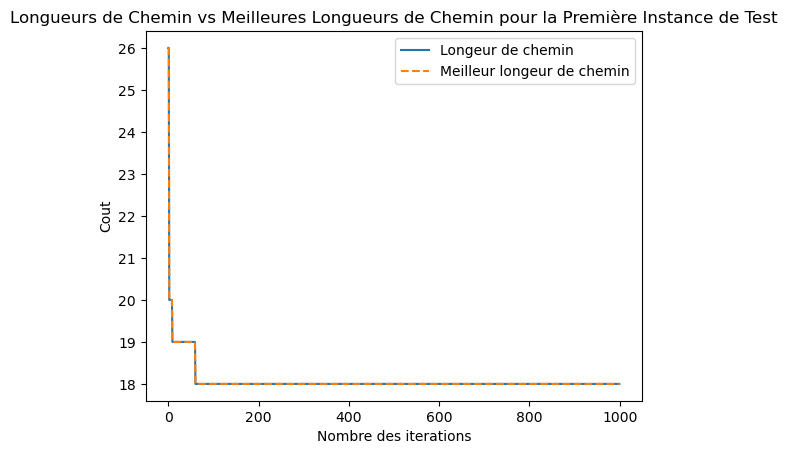

In [722]:
_, _, path_lengths, best_path_lengths = results[0]

iterations = range(len(path_lengths))

plt.plot(iterations, path_lengths, label='Longeur de chemin ')
plt.plot(iterations, best_path_lengths, label='Meilleur longeur de chemin',linestyle='--' )
plt.xlabel('Nombre des iterations')
plt.ylabel('Cout') 
plt.title('Longueurs de Chemin vs Meilleures Longueurs de Chemin pour la Première Instance de Test')
plt.legend()
plt.show()  